In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import glob
import os
import scipy.stats
from matplotlib import cm
import seaborn as sns
import dask
import pickle
import ast

In [3]:
dask.config.set(**{'array.slicing.split_large_chunks': False})

In [4]:
models = [x.split('/')[-1] for x in glob.glob("/terra/data/cmip5/global/rcp85/*")]    

In [5]:
dic = {}

In [6]:
for model in models:
    try:
        rcp85_files = sorted(glob.glob("/terra/data/cmip5/global/rcp85/"+str(model)+"/r1i1p1/mon/native/pr_*"))
        rcp85 = xr.open_mfdataset(rcp85_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').pr
        rcp85 = rcp85.sel(time = slice('2000','2250'))
        hist_files = sorted(glob.glob("/terra/data/cmip5/global/historical/"+str(model)+"/r1i1p1/mon/native/pr_*"))
        hist = xr.open_mfdataset(hist_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').pr
        x = xr.concat([hist,rcp85],dim='time').load()
        x = x.sortby(x.time)
        x = x.resample(time='M').mean()
        dic[model] = x - hist.sel(time=slice('1979','2005')).mean(dim='time')
    except:
        print(model)

BNU-ESM
CNRM-CM5
EC-EARTH
CESM1-WACCM
MPI-ESM-LR


In [7]:
model = 'BNU-ESM' 

# no historical monthly data 

rcp85_files = sorted(glob.glob("/terra/data/cmip5/global/rcp85/"+str(model)+"/r1i1p1/mon/native/pr_*"))
rcp85 = xr.open_mfdataset(rcp85_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').pr
rcp85 = rcp85.sel(time = slice('2000','2250'))
hist_files = sorted(glob.glob("/terra/data/cmip5/global/historical/"+str(model)+"/r1i1p1/day/native/pr_*"))
hist = xr.open_mfdataset(hist_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').pr
hist = hist.resample(time='M').mean()
x = xr.concat([hist,rcp85],dim='time').load()
x = x.sortby(x.time)
x = x.resample(time='M').mean()
dic[model] = x - hist.sel(time=slice('1979','2005')).mean(dim='time')

In [8]:
"EC-EARTH and CESM1-WACCM - no rcp85 available"

'EC-EARTH and CESM1-WACCM - no rcp85 available'

In [9]:
model = 'MPI-ESM-LR'  

# a problem with the later than 2100 data

rcp85_files = sorted(glob.glob("/terra/data/cmip5/global/rcp85/"+str(model)+"/r1i1p1/mon/native/pr_*"))[0]
rcp85 = xr.open_mfdataset(rcp85_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').pr
rcp85 = rcp85.sel(time = slice('2000','2250'))
hist_files = sorted(glob.glob("/terra/data/cmip5/global/historical/"+str(model)+"/r1i1p1/mon/native/pr_*"))
hist = xr.open_mfdataset(hist_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').pr
x = xr.concat([hist,rcp85],dim='time').load()
x = x.sortby(x.time)
x = x.resample(time='M').mean()
dic[model] = x - (x.sel(time=slice('1979','2005')).mean(dim='time'))

In [10]:
model = 'CNRM-CM5'

# a problem with the later than 2100 data

rcp85_files = sorted(glob.glob("/terra/data/cmip5/global/rcp85/"+str(model)+"/r1i1p1/mon/native/pr_*"))[:2]
rcp85 = xr.open_mfdataset(rcp85_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').pr
rcp85 = rcp85.sel(time = slice('2000','2250'))
hist_files = sorted(glob.glob("/terra/data/cmip5/global/historical/"+str(model)+"/r1i1p1/mon/native/pr_*"))
hist = xr.open_mfdataset(hist_files, decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').pr
x = xr.concat([hist,rcp85],dim='time').load()
x = x.sortby(x.time)
x = x.resample(time='M').mean()
dic[model] = x - (x.sel(time=slice('1979','2005')).mean(dim='time'))

In [31]:
#NOAA
x = xr.open_mfdataset('/home/pmarsh/NOAA_2deg/prate.mon.mean.nc', decode_cf=True).sel(lat = -34, method = 'nearest').sel(lon = 18, method = 'nearest').prate
x = x.sortby(x.time)
x = x.resample(time='M').mean()
x = x.sel(time=slice('1940','2016'))
dic['NOAA'] = x - (x.sel(time=slice('1979','2005')).mean(dim='time'))

In [32]:
#ERA5
x = xr.open_mfdataset(sorted(glob.glob('/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5/day/native/pr_*')), decode_cf=True).sel(latitude = -34, method = 'nearest').sel(longitude = 18, method = 'nearest').pr
x = x.sortby(x.time)
x = x.resample(time='M').mean()
dic['ERA5'] = x - (x.sel(time=slice('1979','2005')).mean(dim='time'))

In [13]:
from datetime import datetime

In [14]:
for index in dic:
    date_string = str('1/'+str(dic[index].time[0].dt.month.values)+'/'+str(dic[index].time[0].dt.year.values))
    start = datetime.strptime(date_string, "%d/%m/%Y")
    x = pd.date_range(start, periods=len(dic[index].time), freq='M')
    dic[index]['time'] = x

In [15]:
rolled={}
for index in dic:
    rolled[index] = dic[index].load().rolling(time = 120).mean()

In [16]:
cmip = [model for model in models if model in dic.keys()]

In [17]:
selled = {}
for index in dic:
    selled[index] = rolled[index].sel(time = slice('1979','2100'))

In [18]:
maximum=[]
minimum=[]

for i in range(len(selled['ACCESS1-0'])):
    vals = []
    for model in cmip:
        vals.append(selled[model].values[i])
    minimum.append(np.min(vals))
    maximum.append(np.max(vals))
    
    

cmip_range = xr.Dataset(dict(maximum = (["time"], maximum),minimum = (["time"], minimum)) ,coords=dict(time = selled[model].time))

In [19]:
results = pd.read_csv('results.csv').set_index('Model')
results = [model for model in results.index if model in cmip]

maximum=[]
minimum=[]

for i in range(len(selled['ACCESS1-0'])):
    vals = []
    for model in results:
        vals.append(selled[model].values[i])
    minimum.append(np.min(vals))
    maximum.append(np.max(vals))
    
considered_range = xr.Dataset(dict(maximum = (["time"], maximum),minimum = (["time"], minimum)) ,coords=dict(time = selled[model].time))

In [146]:
winners = ['MIROC-ESM-CHEM','BNU-ESM','CNRM-CM5','GFDL-ESM2M','bcc-csm1-1','ACCESS1-0']


maximum=[]
minimum=[]

for i in range(len(selled['ACCESS1-0'])):
    vals = []
    for model in winners:
        vals.append(selled[model].values[i])
    minimum.append(np.min(vals))
    maximum.append(np.max(vals))
    
winners_range = xr.Dataset(dict(maximum = (["time"], maximum), minimum = (["time"], minimum)) ,coords=dict(time = selled[model].time))

In [65]:
col_dic = pickle.load(open('col_dic.p','rb'))

In [66]:
alpha_offset

0.9000000000000002

In [46]:
counter = 0 
alpha_offset = 0
for end in pd.date_range(start = '1983', end = '2120' , freq='M'):
    fig,ax = plt.subplots(figsize=(16, 9),dpi = 120)
    ax.plot(selled['ERA5'].sel(time = slice ('1950',end)).time, selled['ERA5'].sel(time = slice ('1950',end)).values, color = '#002D52', alpha = 1 , linewidth = 2.8 , label = 'ERA5 Reanalysis')
    ax.plot(selled['NOAA'].sel(time = slice ('1950',end)).time, selled['NOAA'].sel(time = slice ('1950',end)).values, color = '#04015C' , alpha = 1 , linewidth = 3 , label = 'NOAA 20CR Reanalysis')
    if end < pd.to_datetime('2100/01/01'):
        for model in cmip:
            if model in col_dic.keys():
                ax.plot(selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).time, selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).values, color = col_dic[model] , alpha = 1 , linewidth = 4.5)
            else:
                ax.plot(selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).time, selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).values, color = 'grey' , alpha = 0.5 , linewidth = 2)
    elif end < pd.to_datetime('2101/07/01'):
        if apha_offset < 1:
            alpha_offset = alpha_offset+ 0.05
        for model in cmip:
            if model in col_dic.keys():
                ax.plot(selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).time, selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).values, color = col_dic[model] , alpha = (1 - alpha_offset) , linewidth = 4.5)
            else:
                ax.plot(selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).time, selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).values, color = 'grey' , alpha = (0.5 - (alpha_offset/2)) , linewidth = 2)
    x = cmip_range.sel(time = slice ('1950',end - pd.DateOffset(months=240)))
    ax.fill_between(x.time, x.minimum,x.maximum, facecolor='steelblue', alpha=1, label = 'Full Ensemble')
    x = considered_range.sel(time = slice ('1950',end - pd.DateOffset(months=240)))
    ax.fill_between(x.time, x.minimum,x.maximum, facecolor='cadetblue', alpha=1, label = 'Considered Ensemble')
    x = winners_range.sel(time = slice ('1950',end - pd.DateOffset(months=240)))
    ax.fill_between(x.time, x.minimum,x.maximum, facecolor='springgreen', alpha=1, label = 'Final Ensemble')            
    w = ax.axhline(0 , color = '#00ff1e', label = 'Realistic')
    x = ax.axhline(0 , color = '#ffee00', label = 'Bias')
    y = ax.axhline(0 , color = '#ff1100', label = 'Significant Bias')
    z = ax.axhline(0 , color = '#ff00bb', label = 'Unrealistic')
    zz = ax.axhline(0 , color = 'grey',alpha = 0.5, label = 'Not Assessed')
    plt.legend(loc='lower left')
    w.set_visible(False)
    x.set_visible(False)
    y.set_visible(False)
    z.set_visible(False)
    zz.set_visible(False)
    for x in [2e-6,0e-6,-2e-6,-4e-6,-6e-6,-8e-6]:
        ax.axhline(x,color = 'cadetblue', alpha = 0.5)
    ax.axhline(3e-6,color = 'black', alpha = 0.0)
    ax.axhline(-9e-6,color = 'black', alpha = 0.0)
    if end < pd.to_datetime('2100/01/01'):
        plt.xlim([pd.to_datetime('1980/01/01'), end + pd.DateOffset(months=24)])
    else:
        plt.xlim([pd.to_datetime('1980/01/01'), pd.to_datetime('2100/01/01')])
    counter = counter+1
    ax.set_ylim(-10e-6,4e-6)
    plt.ylabel('Mean Rainfall Anomaly (kg m-2 s-1)')
    plt.title('Rainfall Anomaly')
    plt.savefig('Plots/to_gif'+str(counter)+'png')
    plt.close()

Text(0.5, 1.0, 'Rainfall Anomaly')

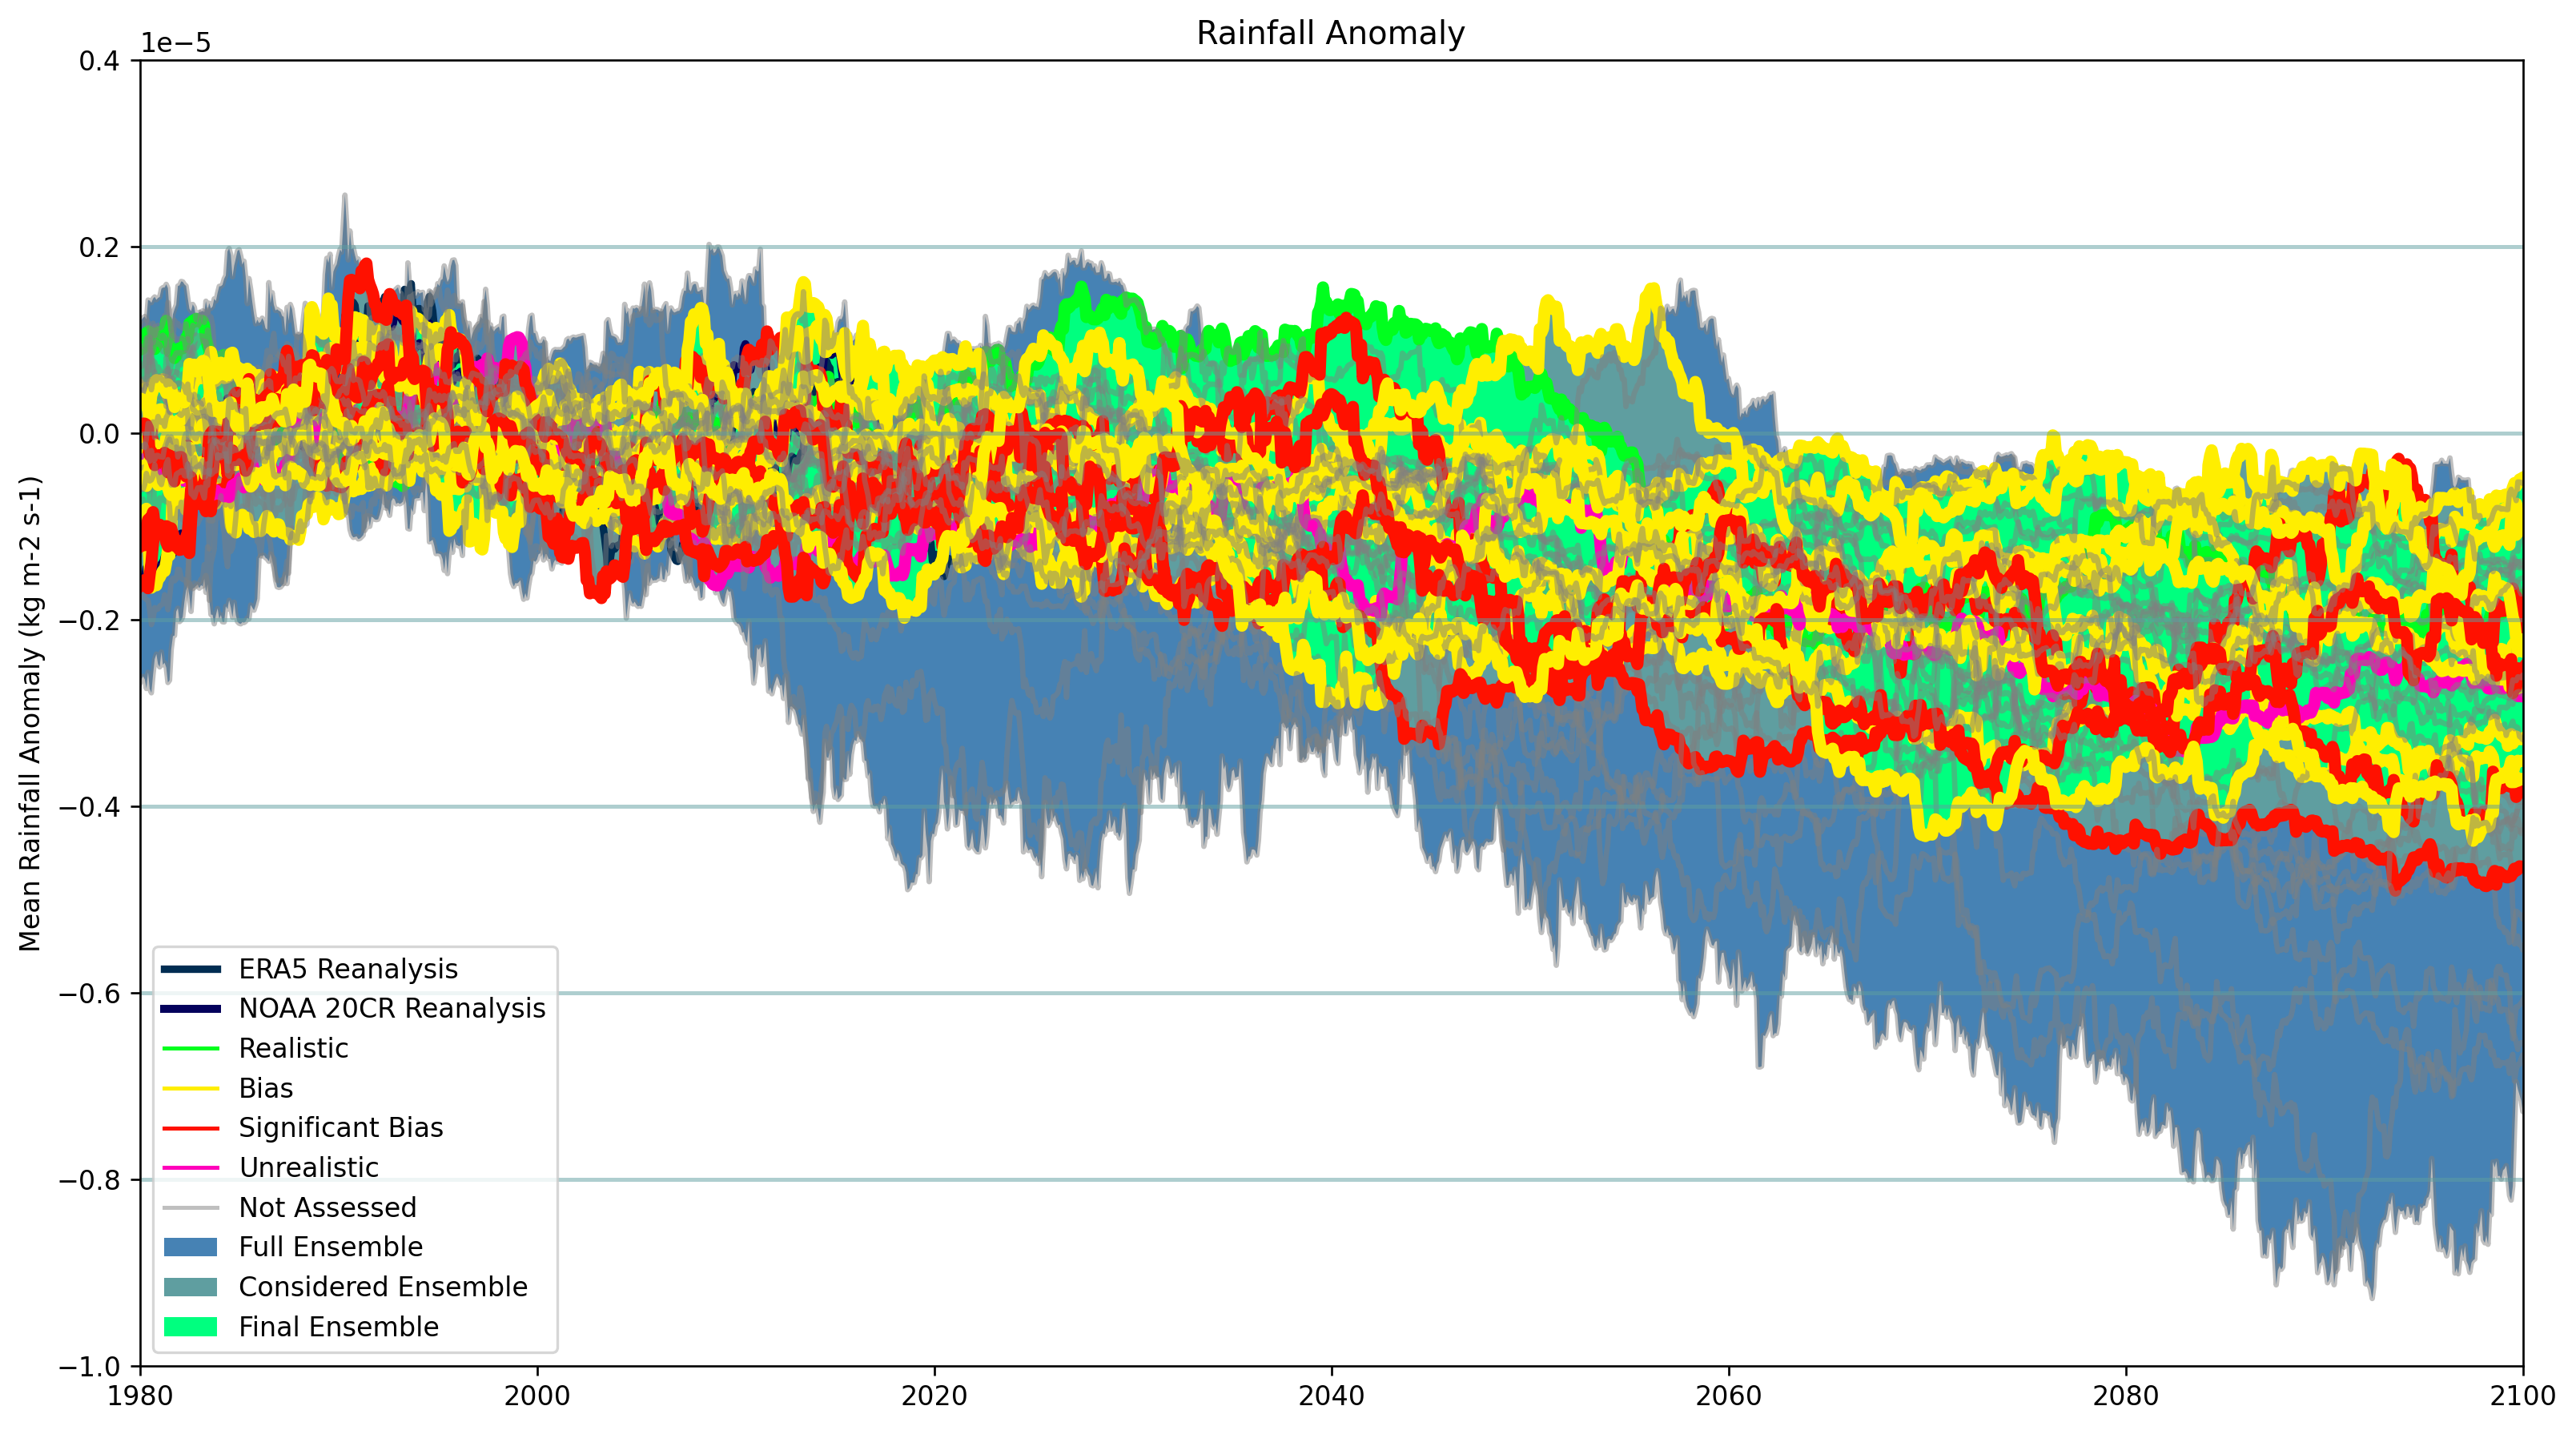

In [151]:
fig,ax = plt.subplots(figsize=(16, 9),dpi = 240)
ax.plot(selled['ERA5'].sel(time = slice ('1950',end)).time, selled['ERA5'].sel(time = slice ('1950',end)).values, color = '#002D52', alpha = 1 , linewidth = 2.8 , label = 'ERA5 Reanalysis')
ax.plot(selled['NOAA'].sel(time = slice ('1950',end)).time, selled['NOAA'].sel(time = slice ('1950',end)).values, color = '#04015C' , alpha = 1 , linewidth = 3 , label = 'NOAA 20CR Reanalysis')
for model in cmip:
    if model in col_dic.keys():
        ax.plot(selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).time, selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).values, color = col_dic[model] , alpha = 1 , linewidth = 4.5)
    else:
        ax.plot(selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).time, selled[model].sel(time = slice ('1950',end - pd.DateOffset(months=120))).values, color = 'grey' , alpha = 0.5 , linewidth = 2)
x = cmip_range.sel(time = slice ('1950',end - pd.DateOffset(months=240)))
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='steelblue', alpha=1, label = 'Full Ensemble')
x = considered_range.sel(time = slice ('1950',end - pd.DateOffset(months=240)))
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='cadetblue', alpha=1, label = 'Considered Ensemble')
x = winners_range.sel(time = slice ('1950',end - pd.DateOffset(months=240)))
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='springgreen', alpha=1, label = 'Final Ensemble')            
w = ax.axhline(0 , color = '#00ff1e', label = 'Realistic')
x = ax.axhline(0 , color = '#ffee00', label = 'Bias')
y = ax.axhline(0 , color = '#ff1100', label = 'Significant Bias')
z = ax.axhline(0 , color = '#ff00bb', label = 'Unrealistic')
zz = ax.axhline(0 , color = 'grey',alpha = 0.5, label = 'Not Assessed')
plt.legend(loc='lower left')
w.set_visible(False)
x.set_visible(False)
y.set_visible(False)
z.set_visible(False)
zz.set_visible(False)
for x in [2e-6,0e-6,-2e-6,-4e-6,-6e-6,-8e-6]:
    ax.axhline(x,color = 'cadetblue', alpha = 0.5)
ax.axhline(3e-6,color = 'black', alpha = 0.0)
ax.axhline(-9e-6,color = 'black', alpha = 0.0)
if end < pd.to_datetime('2100/01/01'):
    plt.xlim([pd.to_datetime('1980/01/01'), end + pd.DateOffset(months=24)])
else:
    plt.xlim([pd.to_datetime('1980/01/01'), pd.to_datetime('2100/01/01')])
counter = counter+1
ax.set_ylim(-10e-6,4e-6)
plt.ylabel('Mean Rainfall Anomaly (kg m-2 s-1)')
plt.title('Rainfall Anomaly')

In [70]:
file = open("../genealogy/Knutti_colours_dict.txt", "r")
contents = file.read()
knutti_dic = ast.literal_eval(contents)
file.close()

In [135]:
ls = {}
for index in col_dic:
    if col_dic[index] == '#00ff1e':
        ls[index] = 4
    elif col_dic[index] == '#ffee00':
        ls[index] = 3
    elif col_dic[index] == '#ff1100':
        ls[index] = 2
    elif col_dic[index] == '#ff00bb':
        ls[index] = 1

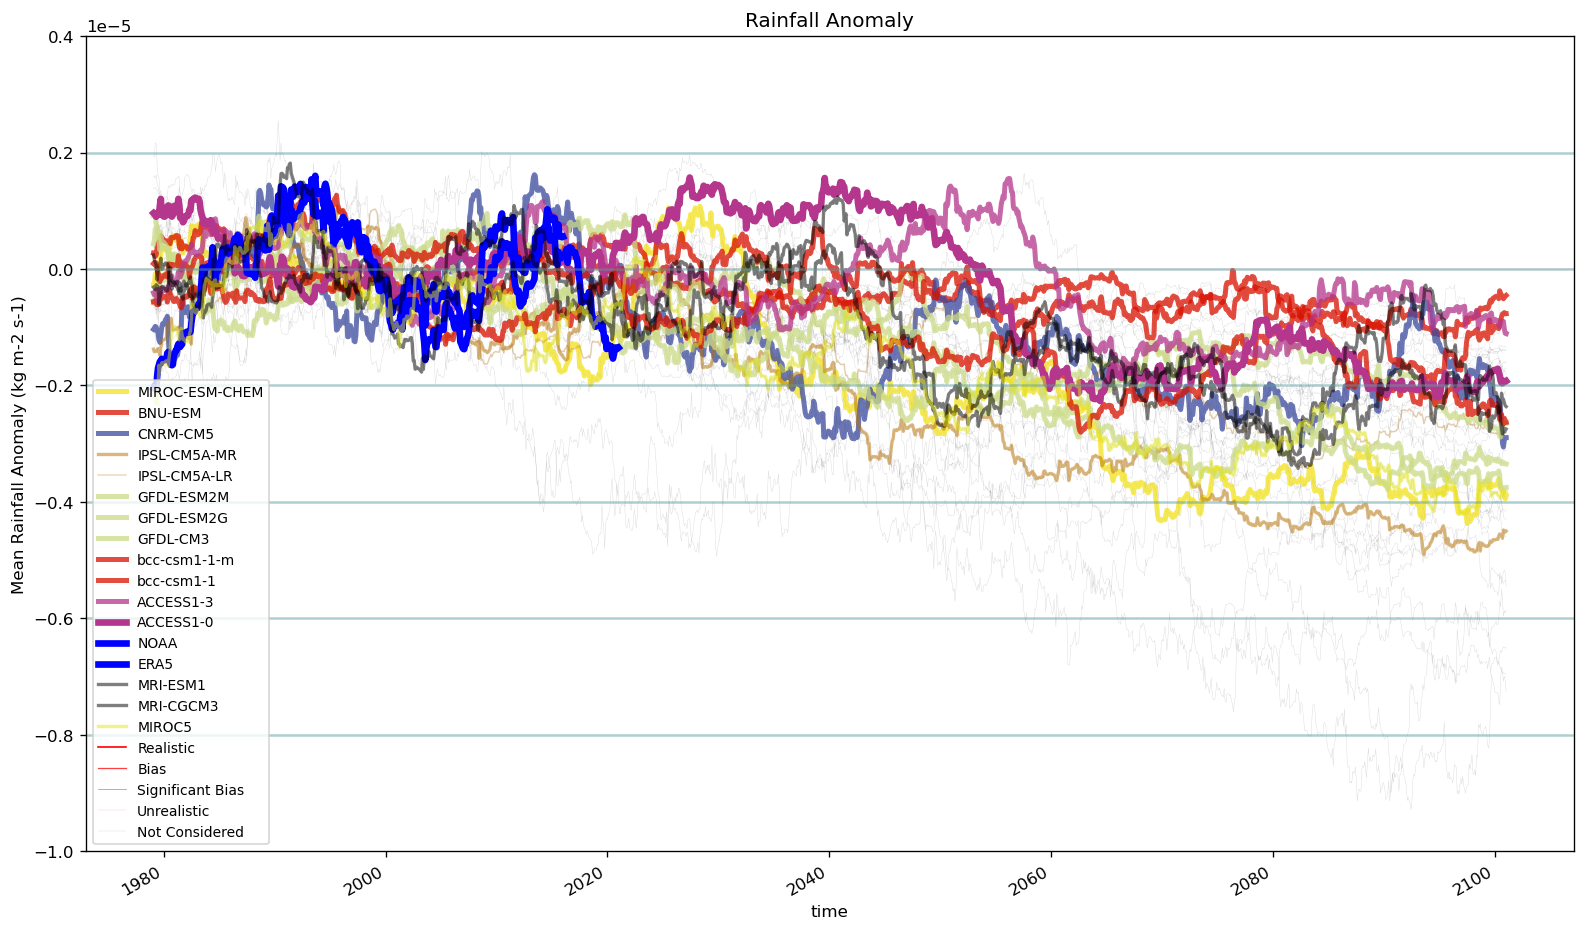

In [153]:
fig,ax = plt.subplots(figsize=(16, 9),dpi = 120)



for index in selled:
    selled[index].plot(color = 'black' , linewidth = 0.25, alpha = 0.15)

for win in col_dic:
    selled[win].plot(label = str(win) , color = knutti_dic[win] , linewidth = ls[win], alpha = ls[win]/4)

    
    

x = winners_range.sel(time = slice ('1950',end - pd.DateOffset(months=240)))
#ax.fill_between(x.time, x.minimum,x.maximum, facecolor='springgreen', alpha=1, label = 'Final Ensemble') 


for x in [2e-6,0e-6,-2e-6,-4e-6,-6e-6,-8e-6]:
    ax.axhline(x,color = 'cadetblue', alpha = 0.5)
ax.axhline(3e-6,color = 'black', alpha = 0.0)
ax.axhline(-9e-6,color = 'black', alpha = 0.0)

w = ax.axhline(0 , color = 'red',  alpha = 1, linewidth = 1, label = 'Realistic')
x = ax.axhline(0 ,color = 'red',  alpha = 3/4, linewidth = 3/4,  label = 'Bias')
y = ax.axhline(0 , color = 'red',  alpha = 2/4, linewidth = 2/4,  label = 'Significant Bias')
z = ax.axhline(0 , color = 'red',  alpha = 1/4, linewidth = 1/4, label = 'Unrealistic')

z = ax.axhline(0 , color = 'black',  alpha = 0.25, linewidth = 0.15, label = 'Not Considered')

plt.legend(loc='lower left', fontsize = 'small')

w.set_visible(False)
x.set_visible(False)
y.set_visible(False)
z.set_visible(False)
zz.set_visible(False)

ax.set_ylim(-10e-6,4e-6)
plt.ylabel('Mean Rainfall Anomaly (kg m-2 s-1)')
plt.title('Rainfall Anomaly')
plt.savefig('pr_family_series.png',dpi=240)
plt.savefig('pr_family_series.pdf')

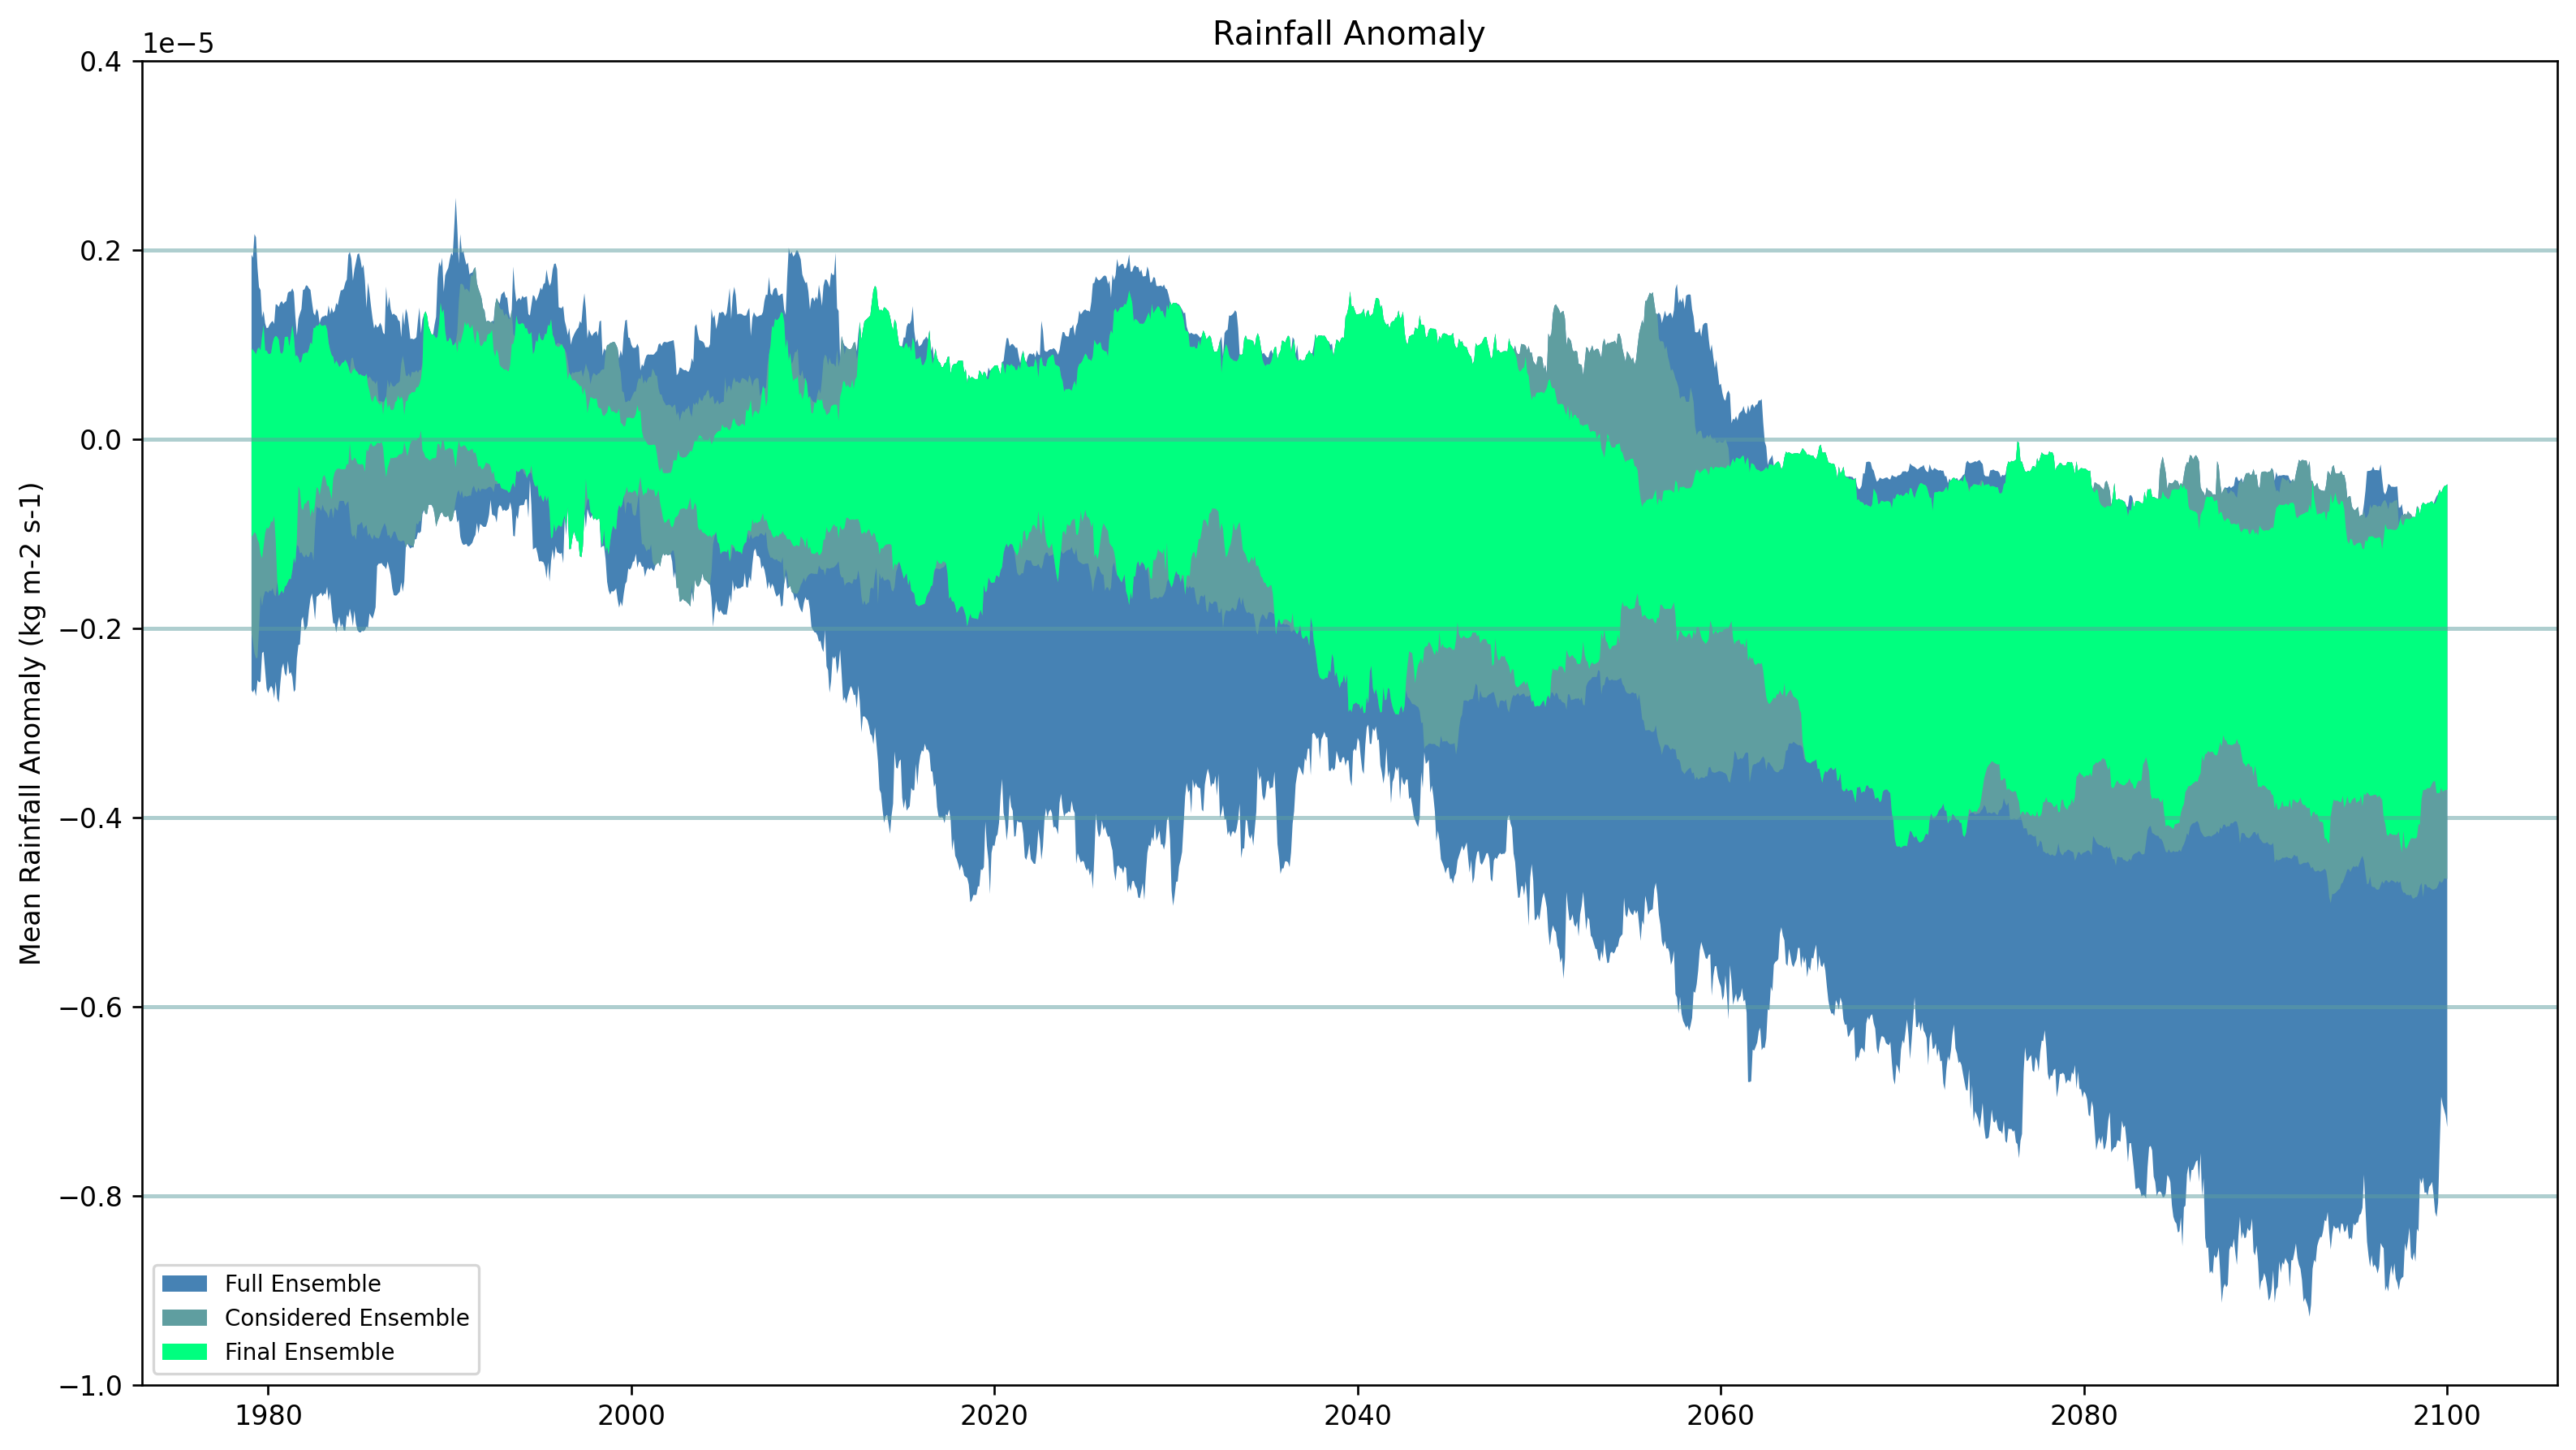

In [152]:
fig,ax = plt.subplots(figsize=(16, 9),dpi = 240)

    
x = cmip_range.sel(time = slice ('1950',end - pd.DateOffset(months=240)))
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='steelblue', alpha=1, label = 'Full Ensemble')
x = considered_range.sel(time = slice ('1950',end - pd.DateOffset(months=240)))
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='cadetblue', alpha=1, label = 'Considered Ensemble')
x = winners_range.sel(time = slice ('1950',end - pd.DateOffset(months=240)))
ax.fill_between(x.time, x.minimum,x.maximum, facecolor='springgreen', alpha=1, label = 'Final Ensemble')     

for x in [2e-6,0e-6,-2e-6,-4e-6,-6e-6,-8e-6]:
    ax.axhline(x,color = 'cadetblue', alpha = 0.5)
ax.axhline(3e-6,color = 'black', alpha = 0.0)
ax.axhline(-9e-6,color = 'black', alpha = 0.0)


ax.set_ylim(-10e-6,4e-6)
plt.ylabel('Mean Rainfall Anomaly (kg m-2 s-1)')
plt.title('Rainfall Anomaly')

plt.legend(loc='lower left', fontsize = 'small')
plt.savefig('pr_selected.png',dpi=240)
plt.savefig('pr_selected.pdf')

In [121]:
2/3

0.6666666666666666